## 4c) Evaluation of Shap Explainer (Deep Explainer) - Tensorflow Model 
### **Note:** (Total runtime approx. 5 minutes)

### This notebook uses two metrics to evalute the effctiveness of SHAP Deep Explainer 
#### 1. `Robustness to Noise:` 
##### Robustness evaluates how well the explanations handle noisy or perturbed data. Robust explainer-model combinations should exhibit minimal changes in the explanations under such perturbations. 
#### 2. `Stability to Validation: `
##### Stability evalutes how stable the explainer results are for different sets of randomised testing data. A more stable explainer should give similar sets of important features for different testing data.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
from matplotlib import pyplot as plt

df = pd.read_csv("../preprocessed/clean_survey.csv", index_col=False)
# split to indenpendent and dependent variables
# drop all variables computing the labels
X = df.drop(['q_031_adjusted', 'invol_score', 'q_031', 'involvement_level'] + [f'q_0{i}' for i in range(45, 55)], axis=1)
y = df["involvement_level"]

# Encode the class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and test sets
X_train, X_test, y_encoded_train, y_encoded_test = train_test_split(X, y_encoded, stratify=y_encoded, random_state=42)

# Data Preprocessing
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Store in dataframe for plotting
feature_names = X_train.columns.tolist()
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
print(label_mapping)

{0: 'High', 1: 'Low', 2: 'Medium'}


In [2]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('../models/neural_1_tensor.h5')

2024-05-26 04:09:09.542685: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-26 04:09:10.781466: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-26 04:09:10.787836: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 04:09:14.791903: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import shap
import pickle
shap.initjs()
# Make sure the input data is in the correct format (e.g., a NumPy array)

shap_explainer = shap.DeepExplainer(model, X_train_scaled)
with open('../shaps/shap_values_deep.pkl', 'rb') as file:
    shap_values_scaled = pickle.load(file)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [4]:
# Retrieve feature names after dropping columns
feature_names = X.columns.tolist()
expected_value = np.array(shap_explainer.expected_value)
#shap_values_scaled = [np.array(sv) for sv in shap_values_scaled]

### 4.1 Robustness to Noise
For the given testing dataset that was used to generate Shapley values, different small noise levels were added to the data to generate perturbed testing samples. Then the explainer was fitted to compute the perturbed Shapley values. To determine robustness, we inspect the correlation between original Shapley values and perturbed Shapley values. The higher the correlations for small noises, the more robust the explainer is to noise.

In [21]:
with open('../shaps/df_feature_contri_deep.pkl', 'rb') as file:
    df_feature_importances = pickle.load(file)
df_feature_importances
features_to_perturb = df_feature_importances[
    (df_feature_importances['RateOfChange'].isna()) | 
    (df_feature_importances['RateOfChange'] >= 3)
]['Feature'].tolist()
perturb_indices = [X_test.columns.get_loc(col) for col in features_to_perturb]
perturb_indices

[4,
 59,
 5,
 18,
 49,
 58,
 22,
 65,
 43,
 20,
 45,
 54,
 21,
 64,
 11,
 63,
 40,
 24,
 51,
 67,
 44,
 19,
 9,
 42,
 13]

In [25]:
def add_per_feature_noise(X, noise_level, perturb_indices, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    X_noisy = X.copy()
    for i in perturb_indices:
        sigma_j = np.std(X.iloc[:, i])
        feature_noise = np.random.normal(0, noise_level * sigma_j, X.iloc[:, i].shape)
        X_noisy.iloc[:, i] += feature_noise
    return X_noisy

In [26]:
# Function to add random noise to the input features
def add_noise(X_scaled, scaler, noise_level, random_state=None):
    """
    Adds Gaussian noise to a standardized dataset.
    
    Parameters:
    X_scaled (np.ndarray): The standardized dataset to perturb.
    scaler (StandardScaler): The fitted scaler with mean and scale information.
    noise_level (float): The standard deviation of the noise relative to the original data's standard deviation.
    
    Returns:
    np.ndarray: The perturbed dataset.
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Retrieve the original scale (standard deviation)
    original_std = scaler.scale_
    
    # Generate Gaussian noise
    noise = np.random.normal(0, noise_level, X_scaled.shape)
    
    # Scale the noise according to the original standard deviations
    scaled_noise = noise * original_std
    
    # Add the scaled noise to the standardized dataset
    X_noisy_scaled = X_scaled + scaled_noise / scaler.scale_
    
    return X_noisy_scaled


# Set the noise levels to evaluate
noise_levels = [0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
random_seeds = [42, 0, 150, 500, 999] 

# Initialize arrays to store the correlation scores for each class
correlation_scores_deep = [[] for _ in range(3)]
mae_scores_deep = [[] for _ in range(3)]
class_index = [1, 2, 0]

# Iterate over the noise levels
for noise_level in noise_levels:
    # Temporary lists to store scores for the current noise level
    temp_corr_scores_deep = [[] for _ in range(3)]    
    temp_mae_scores_deep = [[] for _ in range(3) ]
    for seed in random_seeds:
        # Add noise to the test set with different random seeds
        #X_test_noisy = add_noise(X_test_scaled, scaler, noise_level, random_state=seed)
        X_test_noisy = add_per_feature_noise(X_test, noise_level, perturb_indices, random_state=seed)
        X_test_noisy = scaler.transform(X_test_noisy)
        # Compute SHAP values for the noisy test set
        shap_values_deep_noisy = shap_explainer.shap_values(X_test_noisy)
        
        # Compute correlations and MAE for each class
        for class_idx in class_index:
            corr_deep = np.corrcoef(shap_values_scaled[class_idx].flatten(), shap_values_deep_noisy[class_idx].flatten())[0, 1]
            mae_deep = np.mean(np.abs(shap_values_scaled[class_idx] - shap_values_deep_noisy[class_idx]))
            temp_corr_scores_deep[class_idx].append(corr_deep)
            temp_mae_scores_deep[class_idx].append(mae_deep)
    
    # Compute the average correlation and MAE for the current noise level
    for class_idx in class_index:
        avg_corr_deep = np.mean(temp_corr_scores_deep[class_idx])
        avg_mae_deep = np.mean(temp_mae_scores_deep[class_idx])
        correlation_scores_deep[class_idx].append(avg_corr_deep)
        mae_scores_deep[class_idx].append(avg_mae_deep)


In [27]:
correlation_scores_deep

[[0.011350478840719262,
  0.015102934570597937,
  0.010136852896623503,
  0.020264246766841427,
  0.011763823347017376,
  0.03767843467142028],
 [-0.01672794847701912,
  0.0027869427094727238,
  -0.005898684650144143,
  0.012824747691252894,
  -0.008511884631732055,
  0.033609703290772244],
 [-0.02643908211008781,
  0.0002778587935992248,
  -0.02161911779327607,
  -0.001966311524069942,
  0.010943152853734353,
  0.04233156262660894]]

In [28]:
mae_scores_deep

[[0.039232263066406634,
  0.04174138024665643,
  0.037024023521292214,
  0.029361613987729816,
  0.028545521028576458,
  0.029867709606721093],
 [0.09772182361400027,
  0.12262034562714688,
  0.11499210622960306,
  0.08632489357259136,
  0.08393448523135902,
  0.08852651448967522],
 [0.08962958690451342,
  0.12949562331319214,
  0.10213900454801843,
  0.0807308683836378,
  0.07766317121985906,
  0.08155845242580743]]

### Whole Feature

In [29]:
def add_per_feature_noise(X, noise_level, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    X_noisy = X.copy()
    for i in range(X.shape[1]):
        sigma_j = np.std(X.iloc[:, i])
        feature_noise = np.random.normal(0, noise_level * sigma_j, X.iloc[:, i].shape)
        X_noisy.iloc[:, i] += feature_noise
    return X_noisy


# Set the noise levels to evaluate
noise_levels = [0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
random_seeds = [42, 0, 150, 500, 999] 

# Initialize arrays to store the correlation scores for each class
correlation_scores_deep = [[] for _ in range(3)]
mae_scores_deep = [[] for _ in range(3)]
class_index = [1, 2, 0]

# Iterate over the noise levels
for noise_level in noise_levels:
    # Temporary lists to store scores for the current noise level
    temp_corr_scores_deep = [[] for _ in range(3)]    
    temp_mae_scores_deep = [[] for _ in range(3) ]
    for seed in random_seeds:
        # Add noise to the test set with different random seeds
        #X_test_noisy = add_noise(X_test_scaled, scaler, noise_level, random_state=seed)
        X_test_noisy = add_per_feature_noise(X_test, noise_level, random_state=seed)
        X_test_noisy = scaler.transform(X_test_noisy)
        # Compute SHAP values for the noisy test set
        shap_values_deep_noisy = shap_explainer.shap_values(X_test_noisy)
        
        # Compute correlations and MAE for each class
        for class_idx in class_index:
            corr_deep = np.corrcoef(shap_values_scaled[class_idx].flatten(), shap_values_deep_noisy[class_idx].flatten())[0, 1]
            mae_deep = np.mean(np.abs(shap_values_scaled[class_idx] - shap_values_deep_noisy[class_idx]))
            temp_corr_scores_deep[class_idx].append(corr_deep)
            temp_mae_scores_deep[class_idx].append(mae_deep)
    
    # Compute the average correlation and MAE for the current noise level
    for class_idx in class_index:
        avg_corr_deep = np.mean(temp_corr_scores_deep[class_idx])
        avg_mae_deep = np.mean(temp_mae_scores_deep[class_idx])
        correlation_scores_deep[class_idx].append(avg_corr_deep)
        mae_scores_deep[class_idx].append(avg_mae_deep)

In [30]:
correlation_scores_deep

[[0.05543017779223334,
  0.0056247685512446815,
  0.04723621200698132,
  0.03383013183910891,
  -0.029642321544125765,
  0.019903324156735076],
 [-0.007045388257033286,
  0.012716898881520841,
  -0.010198620434671972,
  0.01663414376265581,
  -0.0007026745017237251,
  0.017124716847095437],
 [0.008726323554772986,
  0.021699636960216817,
  0.015540872262777098,
  0.014455596678506228,
  0.0020733660717832396,
  -0.004125657589825122]]

In [31]:
mae_scores_deep

[[0.041146757752184356,
  0.03395072963526089,
  0.030787443752664716,
  0.03630206312148663,
  0.03129536206014778,
  0.033922189828005364],
 [0.10028135047858037,
  0.09515232300435314,
  0.07639073188508158,
  0.08137174035518813,
  0.10515668844156709,
  0.08575089953575007],
 [0.09476009680074875,
  0.08480605985669924,
  0.0702044824030971,
  0.0743393206409111,
  0.09859805989349223,
  0.07875998597052122]]

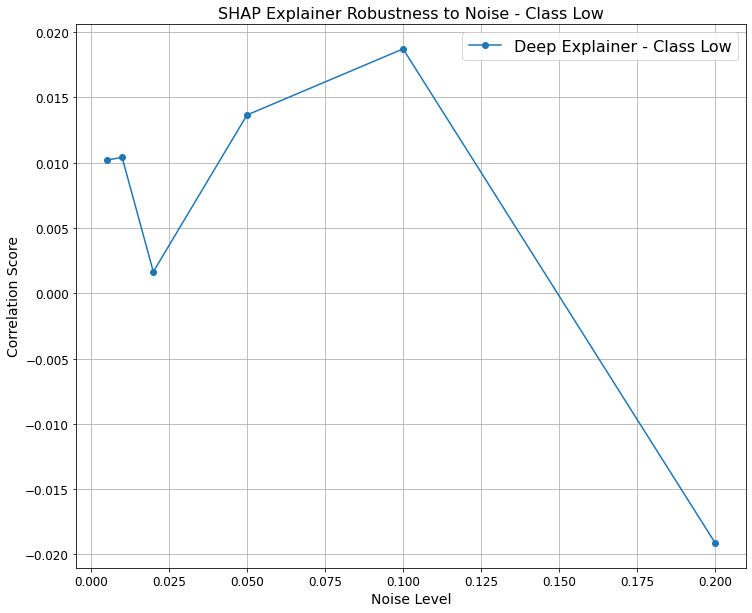

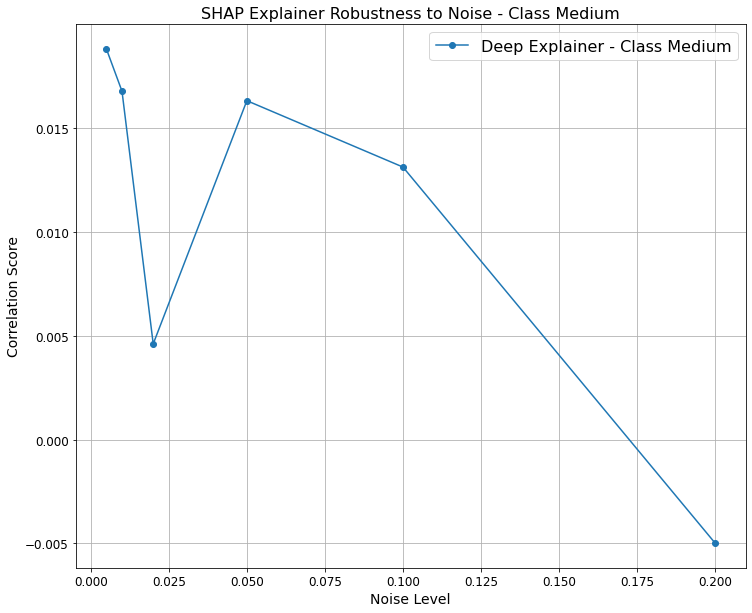

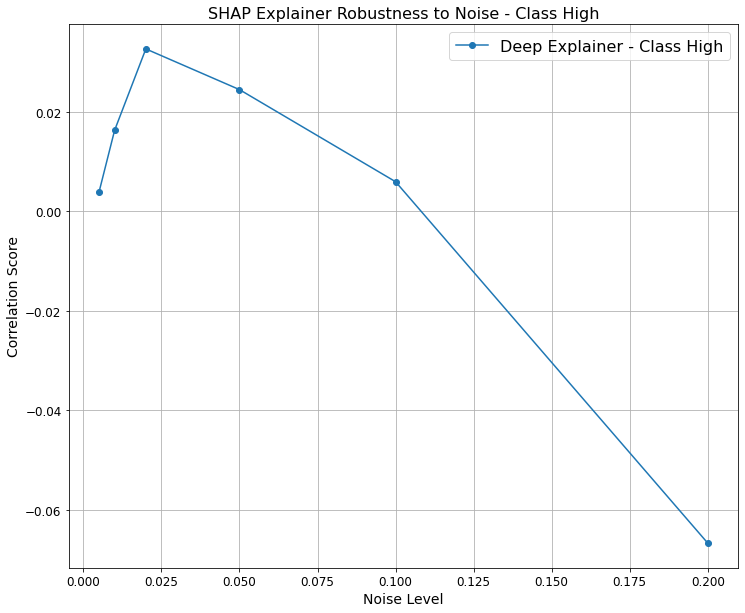

Class Low average rubustness score =  0.005916550441808395
Class Medium average rubustness score =  0.01076872512449452
Class High average rubustness score =  0.002720757398948233


In [9]:
# Plot the correlation scores against noise levels
import matplotlib.pyplot as plt

for class_idx in class_index:
    plt.figure(figsize=(12, 10))
    plt.plot(noise_levels, correlation_scores_deep[class_idx], marker='o', label=f'Deep Explainer - Class {label_mapping[class_idx]}')
    plt.xlabel('Noise Level', fontsize=14)
    plt.ylabel('Correlation Score', fontsize=14)
    plt.title(f'SHAP Explainer Robustness to Noise - Class {label_mapping[class_idx]}', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.show()


for class_idx in class_index:
    avg_robustness = np.mean(correlation_scores_deep[class_idx])
    print(f"Class {label_mapping[class_idx]} average rubustness score = ", avg_robustness)

It appears that the explanations provided by DeepExplainer for the Keras model are highly sensitive to noise. Ideally, high robustness in this context would be indicated by consistently high correlation values (close to 1) across the various noise levels. A potential reason is DeepExplainer itself may not perfectly capture the contribution of input features to the output in certain types of neural network architectures.

### 4.2 Stability to Validation
The original testing (validation) set was split with random state 42. Now we use different random states to generate new testing sets for the explainer to compute Shapley values. We then find the list of top 30 influential features for each random state, and compare the similarities between each list. The more similar the lists of influential features, the more stable the explainer.   

In [10]:
def training_generator(X, y_encoded, model, random_states):
    features_list = []
    for random_state in random_states:
        # Split the dataset into training and test sets
        X_train, X_test, y_encoded_train, y_encoded_test = train_test_split(X, y_encoded, stratify=y_encoded, random_state=random_state)

        # Data Preprocessing
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        shap_explainer = shap.DeepExplainer(model, X_train_scaled)
        shap_values_scaled = shap_explainer.shap_values(X_test_scaled)
        
        # Retrieve feature names after dropping columns
#        feature_names = X.columns.tolist()
#        expected_value = np.array(shap_explainer.expected_value)
        shap_values_scaled = [np.array(sv) for sv in shap_values_scaled]

        # If shap_values is a multi-output (e.g., for multi-class classification), you need to aggregate across all classes.
        # This code assumes shap_values is structured with one element per class (for multi-class) or just a single array for binary.
        # Aggregate SHAP values across all classes, then compute the mean absolute value for each feature
        aggregated_shap = np.sum([np.abs(values) for values in shap_values_scaled], axis=0)

        mean_abs_shap_values = np.mean(aggregated_shap, axis=0)

        # Create a DataFrame for easier manipulation and visualization
        df_feature_importances = pd.DataFrame({
            'Feature': X_train.columns,
            'MeanAbsSHAP': mean_abs_shap_values
        }).sort_values(by='MeanAbsSHAP', ascending=False)

        # Step 5: Identify the most important features based on mean absolute SHAP values
        top_features_list = df_feature_importances.head(30)['Feature'].tolist()
        features_list.append(top_features_list)
        
    return features_list


In [11]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('../models/neural_1_tensor.h5')
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 192)               17664     
                                                                 
 dropout (Dropout)           (None, 192)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                6176      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                1

In [12]:
random_states = [1, 20, 42, 150, 250, 500, 1000]
importance_feature_lists = training_generator(X, y_encoded, model, random_states)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be remo

In [13]:
importance_feature_lists

[['q_094',
  'q_093',
  'q_029',
  'q_022',
  'q_105',
  'q_113',
  'q_080',
  'q_100',
  'q_043',
  'q_101',
  'q_020',
  'q_011',
  'q_015',
  'q_088',
  'q_021',
  'q_121',
  'q_024',
  'q_083',
  'q_018',
  'q_036',
  'q_034',
  'q_009',
  'q_000',
  'q_005',
  'q_004',
  'q_006',
  'q_012',
  'q_023',
  'q_037',
  'q_025'],
 ['q_005',
  'q_021',
  'q_106',
  'q_030',
  'q_085',
  'q_006',
  'q_092',
  'q_130_QLD',
  'q_039',
  'q_013',
  'q_123_rural',
  'q_025',
  'q_037',
  'q_014',
  'q_110',
  'q_111',
  'q_023',
  'q_105',
  'q_018',
  'q_113',
  'q_011',
  'q_112',
  'q_116',
  'q_086',
  'q_015',
  'q_093',
  'q_094',
  'q_083',
  'q_107',
  'q_029'],
 ['q_005',
  'q_106',
  'q_006',
  'q_021',
  'q_092',
  'q_105',
  'q_025',
  'q_112',
  'q_086',
  'q_023',
  'q_088',
  'q_101',
  'q_024',
  'q_111',
  'q_013',
  'q_110',
  'q_083',
  'q_029',
  'q_094',
  'q_114',
  'q_087',
  'q_022',
  'q_011',
  'q_085',
  'q_015',
  'q_084',
  'q_080',
  'q_107',
  'q_043',
  'q_125_

In [14]:
def count_pairwise_common_elements(lists):
    common_counts = {}
    for i in range(len(lists)):
        for j in range(i+1, len(lists)):
            common_elements = set(lists[i]) & set(lists[j])
            common_counts[(i, j)] = len(common_elements)
    return common_counts


pairwise_common_counts = count_pairwise_common_elements(importance_feature_lists)
print("Pairwise common elements counts:")
for pair, count in pairwise_common_counts.items():
    print("Lists {} and {}: {} common elements".format(pair[0]+1, pair[1]+1, count))

Pairwise common elements counts:
Lists 1 and 2: 15 common elements
Lists 1 and 3: 17 common elements
Lists 1 and 4: 18 common elements
Lists 1 and 5: 14 common elements
Lists 1 and 6: 17 common elements
Lists 1 and 7: 17 common elements
Lists 2 and 3: 20 common elements
Lists 2 and 4: 20 common elements
Lists 2 and 5: 17 common elements
Lists 2 and 6: 19 common elements
Lists 2 and 7: 20 common elements
Lists 3 and 4: 25 common elements
Lists 3 and 5: 20 common elements
Lists 3 and 6: 26 common elements
Lists 3 and 7: 20 common elements
Lists 4 and 5: 20 common elements
Lists 4 and 6: 24 common elements
Lists 4 and 7: 20 common elements
Lists 5 and 6: 19 common elements
Lists 5 and 7: 22 common elements
Lists 6 and 7: 22 common elements


In [15]:
def weighted_jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection_size = len(set1.intersection(set2))
    union_size = len(set1.union(set2))
    return intersection_size / union_size

def compute_similarity_scores(lists):
    similarity_scores = []
    for i in range(len(lists)):
        for j in range(i+1, len(lists)):
            similarity_scores.append(weighted_jaccard_similarity(lists[i], lists[j]))
    return similarity_scores

pairwise_similarity_scores = compute_similarity_scores(importance_feature_lists)
overall_similarity_score = sum(pairwise_similarity_scores) / len(pairwise_similarity_scores)
print("Overall Jaccard similarity score:", overall_similarity_score)

Overall Jaccard similarity score: 0.49419191453662087
